Old Yeller Text Analysis **I need to fix the not found sections of the major plot points, and clean it up since it runs, but doesn't run fast, so I might have to do a chunk by chunk analysis of text.**

Extracted characters: 186079


Device set to use cpu



Average sentiment for the whole book: -0.544

Character Sentiments:
Old Yeller: -0.328
Travis: -0.318
Arliss: -0.243
Mama: -0.407
Papa: -0.174

Plot Point Sentiments:
bear attack: not found
disease: not found
Old Yeller saves: not found
Old Yeller dies: not found
hunting: -0.223
school: not found


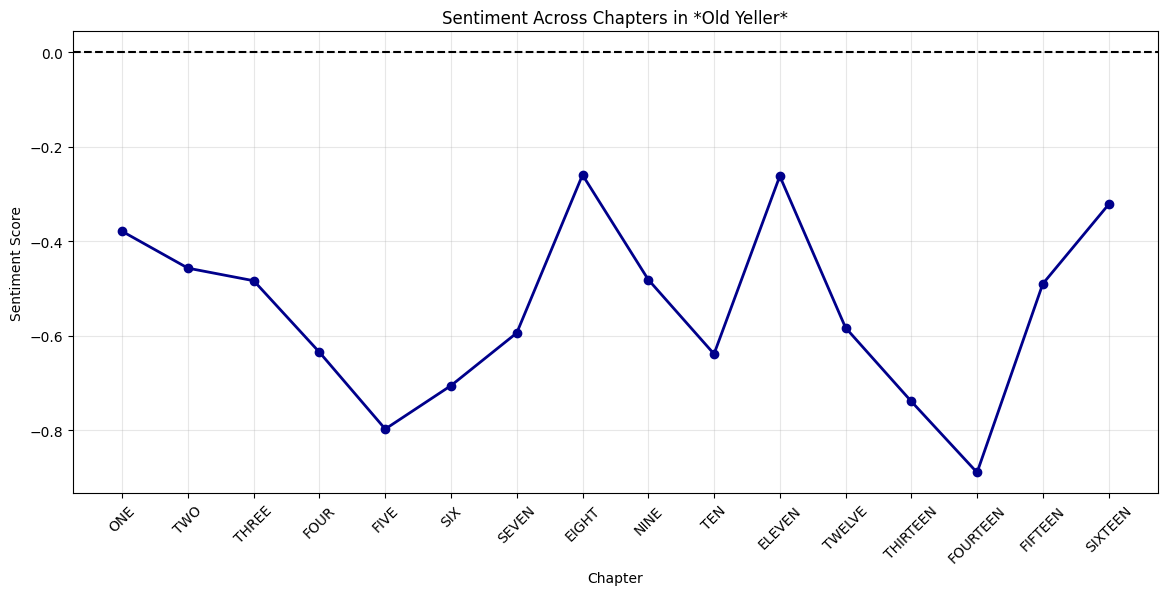

In [ ]:
# install packages
!pip install pypdf transformers torch --quiet

# IMPORT LIBRARIES
from pypdf import PdfReader
import re
import matplotlib.pyplot as plt
from transformers import pipeline
import os

# ============================================================
# SET PDF PATH
# ============================================================
pdf_path = "/content/drive/MyDrive/Old Yeller.pdf"  # <-- your path

if not os.path.isfile(pdf_path):
    raise FileNotFoundError(f"The file {pdf_path} was not found.")

# ============================================================
# READ PDF
# ============================================================
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    page_text = page.extract_text()
    if page_text:
        text += page_text + "\n"

print("Extracted characters:", len(text))

# ============================================================
# CHAPTER SPLIT
# ============================================================
chapter_names = [
    "ONE","TWO","THREE","FOUR","FIVE","SIX","SEVEN","EIGHT",
    "NINE","TEN","ELEVEN","TWELVE","THIRTEEN","FOURTEEN",
    "FIFTEEN","SIXTEEN"
]

pattern = r"\n(" + "|".join(chapter_names) + r")\s*\n"
splits = re.split(pattern, text)

chapters = {}
for i in range(1, len(splits), 2):
    title = splits[i]
    content = splits[i+1]
    chapters[title] = content.strip()

# ============================================================
# SENTIMENT PIPELINE
# ============================================================
# Explicitly supply the model
sentiment = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

# ============================================================
# CHAPTER SENTIMENT
# ============================================================
chapter_sentiments = {}
for title, content in chapters.items():
    chunks = [content[i:i+500] for i in range(0, len(content), 500)]
    scores = []
    for c in chunks:
        result = sentiment(c[:500])[0]
        score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
        scores.append(score)
    chapter_sentiments[title] = sum(scores) / len(scores)

# ============================================================
# AVERAGE BOOK SENTIMENT
# ============================================================
average_book_sentiment = sum(chapter_sentiments.values()) / len(chapter_sentiments)
print(f"\nAverage sentiment for the whole book: {average_book_sentiment:.3f}")

# ============================================================
# CHARACTER SENTIMENT
# ============================================================
characters = ["Old Yeller", "Travis", "Arliss", "Mama", "Papa"]
character_sentiments = {}

for char in characters:
    mentions = [m.start() for m in re.finditer(char, text)]
    if mentions:
        chunk_scores = []
        for idx in mentions:
            snippet = text[max(idx-100,0):idx+100]
            result = sentiment(snippet[:500])[0]
            score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
            chunk_scores.append(score)
        character_sentiments[char] = sum(chunk_scores) / len(chunk_scores)
    else:
        character_sentiments[char] = None

print("\nCharacter Sentiments:")
for char, score in character_sentiments.items():
    if score is not None:
        print(f"{char}: {score:.3f}")
    else:
        print(f"{char}: not mentioned")

# ============================================================
# MAIN PLOT POINT SENTIMENT
# ============================================================
plot_points = ["bear attack", "disease", "Old Yeller saves", "Old Yeller dies", "hunting", "school"]
plot_sentiments = {}

for point in plot_points:
    mentions = [m.start() for m in re.finditer(point, text, re.IGNORECASE)]
    if mentions:
        chunk_scores = []
        for idx in mentions:
            snippet = text[max(idx-100,0):idx+100]
            result = sentiment(snippet[:500])[0]
            score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
            chunk_scores.append(score)
        plot_sentiments[point] = sum(chunk_scores) / len(chunk_scores)
    else:
        plot_sentiments[point] = None

print("\nPlot Point Sentiments:")
for point, score in plot_sentiments.items():
    if score is not None:
        print(f"{point}: {score:.3f}")
    else:
        print(f"{point}: not found")

# ============================================================
# PLOT CHAPTER SENTIMENT
# ============================================================
ordered = chapter_names
values = [chapter_sentiments[c] for c in ordered]

plt.figure(figsize=(14,6))
plt.plot(range(1, len(values)+1), values, marker="o", linewidth=2, color="darkblue")
plt.axhline(0, color='black', linestyle='--')
plt.xticks(range(1, len(values)+1), ordered, rotation=45)
plt.xlabel("Chapter")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Across Chapters in *Old Yeller*")
plt.grid(True, alpha=0.3)
plt.show()